In [1]:
"""
Play the RF mapping for one unit.

Tony Fu, July 8, 2022
"""
import os
import sys
import math

import numpy as np
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import AlexNet_Weights, VGG16_Weights
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

sys.path.append('..')
from spatial import (get_conv_output_shapes,
                     calculate_center,
                     get_rf_sizes,
                     RfGrid,
                     SpatialIndexConverter,)
from image import make_box, preprocess_img_to_tensor
from hook import ConvUnitCounter
from stimulus import draw_bar
from files import delete_all_npy_files
import constants as c

In [10]:
# Please specify some details here:
model = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1).to(c.DEVICE)
model_name = 'alexnet'
# model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(c.DEVICE)
# model_name = 'vgg16'
xn = yn = 227
spatial_index = (11, 11)
rf_blen_ratios = [3/4, 3/8, 3/16, 3/32]
rf_blen_ratio_strs = ['3/4', '3/8', '3/16', '3/32']
aspect_ratios = [1/2, 1/5, 1/10]
thetas = np.arange(0, 180, 22.5)
laa = 0.5
fgval = 1.0
bgval = 0.5
threshold = 1  # for threshold cumulation maps.
this_is_a_test_run = True

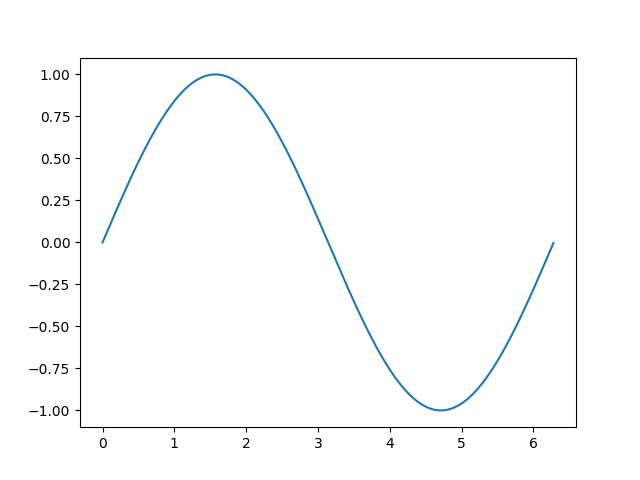

In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# %matplotlib ipympl

# fig, ax = plt.subplots()

# x = np.arange(0, 2*np.pi, 0.01)
# line, = ax.plot(x, np.sin(x))

# def init():
#     line.set_ydata([np.nan] * len(x))
#     return line,

# def animate(i):
#     line.set_ydata(np.sin(x + i / 100))  # update the data.
#     return line,

# ani = animation.FuncAnimation(
#     fig, animate, init_func=init, interval=2, blit=True, save_count=50)

# plt.show()

In [ ]:
for blen_i, rf_blen_ratio in enumerate(rf_blen_ratios):
        for bwid_i, aspect_ratio in enumerate(aspect_ratios):
            for theta_i, theta in enumerate(thetas):
                for val_i, (fgval, bgval) in enumerate([(1, -1), (-1, 1)]):
                    # Some bar parameters
                    blen = round(rf_blen_ratio * rf_size)
                    bwid = round(aspect_ratio * blen)
                    grid_spacing = blen/2
                    
                    # Get grid coordinates.
                    grid_coords = bar_locations.get_grid_coords(layer_index, spatial_index, grid_spacing)
                    grid_coords_np = np.array(grid_coords)

                    # Create bars.
                    for grid_coord_i, (xc, yc) in enumerate(grid_coords_np):
                        if this_is_a_test_run and grid_coord_i > 10:
                            break
                        
                        bar = draw_bar(xn, yn, xc, yc, theta, blen, bwid, laa, fgval, bgval)
                        bar_tensor = preprocess_img_to_tensor(bar)
                        y, _ = truncated_model(bar_tensor, model, layer_index)
                        center_responses = y[0, :, spatial_index[0], spatial_index[1]].cpu().detach().numpy()
                        center_responses[center_responses < 0] = 0  # ReLU
                        unit_blen_bwid_theta_val_responses[:, blen_i, bwid_i, theta_i, val_i] += center_responses[:]
                        num_stimuli += 1
                        print_progress(num_stimuli)

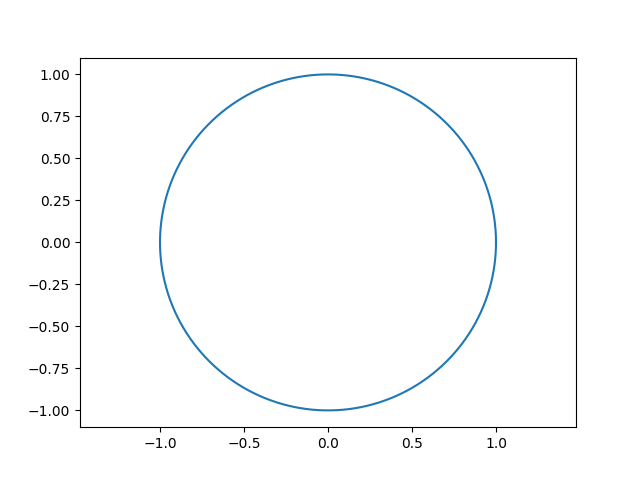

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib ipympl


def plot_unit_circle():
    angs = np.linspace(0, 2 * np.pi, 10**6)
    rs = np.zeros_like(angs) + 1
    xs = rs * np.cos(angs)
    ys = rs * np.sin(angs)
    plt.plot(xs, ys)


def mouse_move(event):
    x, y = event.xdata, event.ydata
    print(x, y)


plt.connect('motion_notify_event', mouse_move)
plot_unit_circle()
plt.axis('equal')
plt.show()

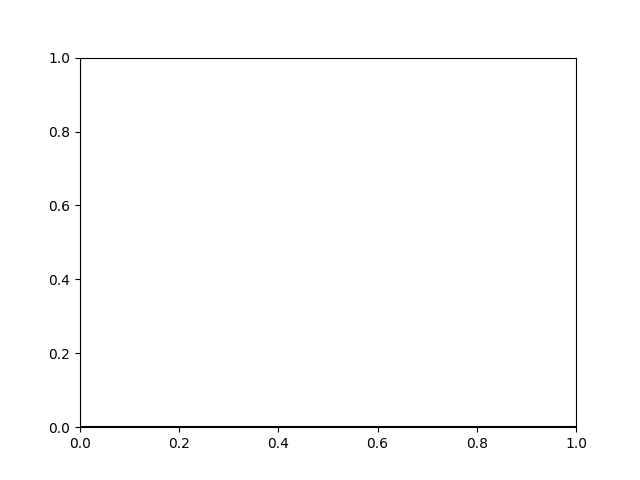

In [6]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np


class Cursor(object):
    def __init__(self, ax):
        self.ax = ax
        self.lx = ax.axhline(color='k')  # the horiz line
        self.ly = ax.axvline(color='k')  # the vert line

        # text location in axes coords
        self.txt = ax.text(0.7, 0.9, '', transform=ax.transAxes)

    def mouse_move(self, event):
        if not event.inaxes:
            return

        x, y = event.xdata, event.ydata
        # update the line positions
        self.lx.set_ydata(y)
        self.ly.set_xdata(x)

        self.txt.set_text('x=%1.2f, y=%1.2f' % (x, y))
        plt.draw()


class SnaptoCursor(object):
    """
    Like Cursor but the crosshair snaps to the nearest x,y point
    For simplicity, I'm assuming x is sorted
    """

    def __init__(self, ax, x, y):
        self.ax = ax
        self.lx = ax.axhline(color='k')  # the horiz line
        self.ly = ax.axvline(color='k')  # the vert line
        self.x = x
        self.y = y
        # text location in axes coords
        self.txt = ax.text(0.7, 0.9, '', transform=ax.transAxes)

    def mouse_move(self, event):

        if not event.inaxes:
            return

        x, y = event.xdata, event.ydata

        indx = np.searchsorted(self.x, [x])[0]
        x = self.x[indx]
        y = self.y[indx]
        # update the line positions
        self.lx.set_ydata(y)
        self.ly.set_xdata(x)

        self.txt.set_text('x=%1.2f, y=%1.2f' % (x, y))
        print('x=%1.2f, y=%1.2f' % (x, y))
        plt.draw()

t = np.arange(0.0, 1.0, 0.01)
s = np.sin(2*2*np.pi*t)
fig, ax = plt.subplots()

#cursor = Cursor(ax)
cursor = SnaptoCursor(ax, t, s)
plt.connect('motion_notify_event', cursor.mouse_move)

# ax.plot(t, s, 'o')
# plt.axis([0, 1, -1, 1])
plt.show()